# Mean Absolute Percentage Error (MAPE)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

# Configuración general
np.random.seed(42)


In [4]:
# Generar datos sintéticos de ventas de e-commerce
n_samples = 1000

# Características
precio = np.random.uniform(10, 500, n_samples)
publicidad = np.random.uniform(100, 5000, n_samples)
temporada = np.random.choice([0.8, 1.0, 1.2, 1.5], n_samples)
competencia = np.random.uniform(0.5, 1.5, n_samples)

# Variable objetivo: ventas
ventas = (
    50 + 
    0.8 * precio + 
    0.02 * publicidad + 
    100 * temporada + 
    -30 * competencia + 
    np.random.normal(0, 20, n_samples)
)

# Asegurar valores positivos
ventas = np.maximum(ventas, 10)


In [6]:
# Crear DataFrame
df = pd.DataFrame({
    'precio': precio,
    'publicidad': publicidad,
    'temporada': temporada,
    'competencia': competencia,
    'ventas': ventas
})

print("Estadísticas descriptivas de las ventas:")
print(df['ventas'].describe())


Estadísticas descriptivas de las ventas:
count    1000.000000
mean      384.441481
std       123.308864
min       112.259822
25%       283.326401
50%       382.543362
75%       485.881216
max       685.110349
Name: ventas, dtype: float64


In [8]:
# Preparar datos
X = df[['precio', 'publicidad', 'temporada', 'competencia']]
y = df['ventas']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entrenar modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")



Linear Regression:
  MAE: 16.97
  RMSE: 21.35
  MAPE: 5.11%

Random Forest:
  MAE: 19.69
  RMSE: 24.35
  MAPE: 5.92%


In [10]:
# Función para calcular MAPE robusto
def calculate_mape(y_true, y_pred, epsilon=1e-8):
    """
    Calcula MAPE de forma robusta, evitando división por cero.
    """
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, epsilon))) * 100


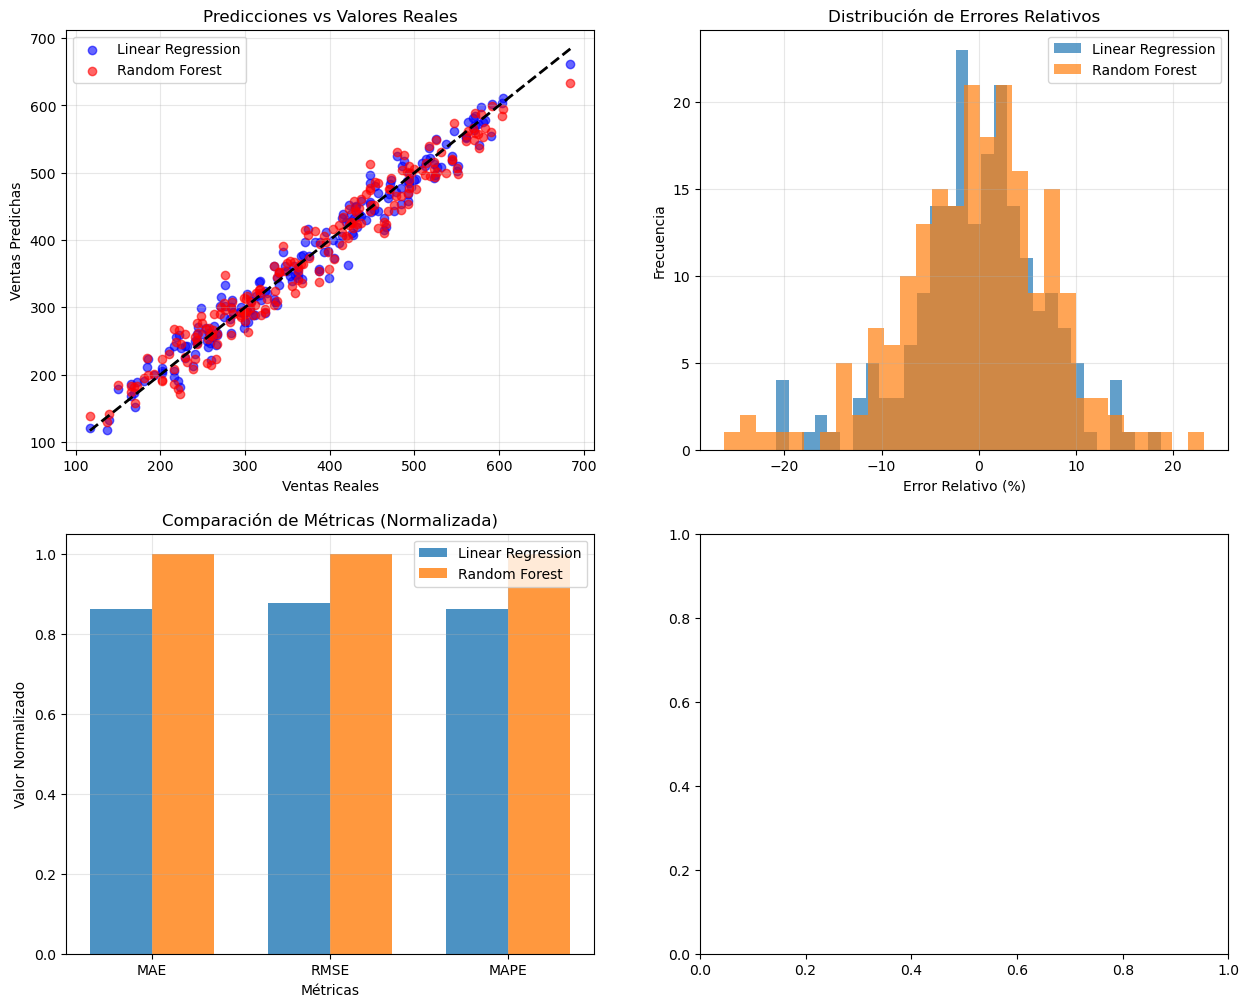

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# --- Gráfico 1: Predicciones vs Reales ---
ax1 = axes[0, 0]
colors = ['blue', 'red']
for i, (name, model) in enumerate(models.items()):
    y_pred = results[name]['predictions']
    ax1.scatter(y_test, y_pred, alpha=0.6, color=colors[i], label=name)

ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax1.set_xlabel('Ventas Reales')
ax1.set_ylabel('Ventas Predichas')
ax1.set_title('Predicciones vs Valores Reales')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Gráfico 2: Distribución de errores relativos ---
ax2 = axes[0, 1]
for name in models.keys():
    y_pred = results[name]['predictions']
    relative_errors = (y_test - y_pred) / y_test * 100
    ax2.hist(relative_errors, bins=30, alpha=0.7, label=name)

ax2.set_xlabel('Error Relativo (%)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Errores Relativos')
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Gráfico 3: Comparación de métricas ---
ax3 = axes[1, 0]
metrics = ['MAE', 'RMSE', 'MAPE']
x_pos = np.arange(len(metrics))
width = 0.35

linear_values = [results['Linear Regression'][m] for m in metrics]
rf_values = [results['Random Forest'][m] for m in metrics]

# Normalizar para comparación
linear_norm = [v / max(linear_values[i], rf_values[i]) for i, v in enumerate(linear_values)]
rf_norm = [v / max(linear_values[i], rf_values[i]) for i, v in enumerate(rf_values)]

ax3.bar(x_pos - width/2, linear_norm, width, label='Linear Regression', alpha=0.8)
ax3.bar(x_pos + width/2, rf_norm, width, label='Random Forest', alpha=0.8)
ax3.set_xlabel('Métricas')
ax3.set_ylabel('Valor Normalizado')
ax3.set_title('Comparación de Métricas (Normalizada)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.grid(True, alpha=0.3)


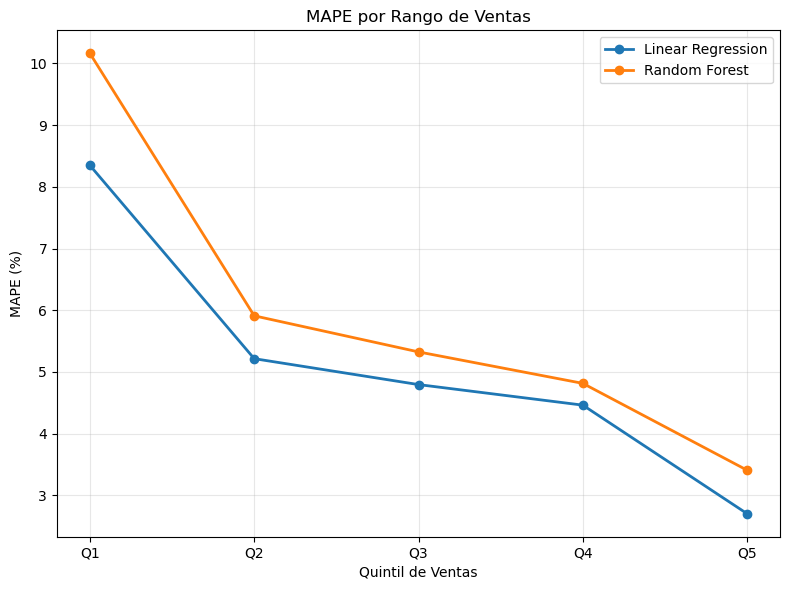

In [20]:
# Crear figura independiente
fig, ax4 = plt.subplots(figsize=(8, 6))

# Calcular quintiles y rangos
quintiles = np.quantile(y_test, [0.2, 0.4, 0.6, 0.8])
ranges = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

# Calcular MAPE por quintil para cada modelo
for name in models.keys():
    y_pred = results[name]['predictions']
    mape_by_range = []
    
    for i in range(5):
        if i == 0:
            mask = y_test <= quintiles[0]
        elif i == 4:
            mask = y_test > quintiles[3]
        else:
            mask = (y_test > quintiles[i-1]) & (y_test <= quintiles[i])
        
        if np.sum(mask) > 0:
            mape_range = calculate_mape(y_test[mask], y_pred[mask])
            mape_by_range.append(mape_range)
        else:
            mape_by_range.append(0)
    
    ax4.plot(ranges, mape_by_range, marker='o', linewidth=2, label=name)

# Personalizar gráfico
ax4.set_xlabel('Quintil de Ventas')
ax4.set_ylabel('MAPE (%)')
ax4.set_title('MAPE por Rango de Ventas')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
print("\n" + "="*50)
print("ANÁLISIS COMPARATIVO DE MÉTRICAS")
print("="*50)

print("\nMAE (Mean Absolute Error):")
print("- Unidades originales, fácil de interpretar")
print("- No penaliza valores grandes desproporcionadamente")
print("- Mejor para datos con outliers")

print("\nRMSE (Root Mean Square Error):")
print("- Penaliza errores grandes más severamente")
print("- Sensible a outliers")
print("- Bueno cuando errores grandes son especialmente indeseables")

print("\nMAPE (Mean Absolute Percentage Error):")
print("- Interpretación intuitiva como porcentaje")
print("- Permite comparar entre diferentes escalas")
print("- Problemático con valores cercanos a cero")
print("- Sesgo hacia subestimaciones")



ANÁLISIS COMPARATIVO DE MÉTRICAS

MAE (Mean Absolute Error):
- Unidades originales, fácil de interpretar
- No penaliza valores grandes desproporcionadamente
- Mejor para datos con outliers

RMSE (Root Mean Square Error):
- Penaliza errores grandes más severamente
- Sensible a outliers
- Bueno cuando errores grandes son especialmente indeseables

MAPE (Mean Absolute Percentage Error):
- Interpretación intuitiva como porcentaje
- Permite comparar entre diferentes escalas
- Problemático con valores cercanos a cero
- Sesgo hacia subestimaciones


In [18]:
print("\n" + "="*50)
print("DEMOSTRACIÓN DEL SESGO DE MAPE")
print("="*50)

# Caso simétrico
y_true_demo = np.array([100, 100])
y_pred_demo1 = np.array([90, 110])
y_pred_demo2 = np.array([110, 90])

mape_demo1 = calculate_mape(y_true_demo, y_pred_demo1)
mape_demo2 = calculate_mape(y_true_demo, y_pred_demo2)

print(f"Valores reales: {y_true_demo}")
print(f"Predicciones 1: {y_pred_demo1} -> MAPE: {mape_demo1:.2f}%")
print(f"Predicciones 2: {y_pred_demo2} -> MAPE: {mape_demo2:.2f}%")

# Caso realista
y_true_demo_real = np.array([50, 150])
y_pred_over = np.array([55, 165])
y_pred_under = np.array([45, 135])

mape_over = calculate_mape(y_true_demo_real, y_pred_over)
mape_under = calculate_mape(y_true_demo_real, y_pred_under)

print(f"\nCaso más realista:")
print(f"Valores reales: {y_true_demo_real}")
print(f"Sobreestimación 10%: {y_pred_over} -> MAPE: {mape_over:.2f}%")
print(f"Subestimación 10%: {y_pred_under} -> MAPE: {mape_under:.2f}%")



DEMOSTRACIÓN DEL SESGO DE MAPE
Valores reales: [100 100]
Predicciones 1: [ 90 110] -> MAPE: 10.00%
Predicciones 2: [110  90] -> MAPE: 10.00%

Caso más realista:
Valores reales: [ 50 150]
Sobreestimación 10%: [ 55 165] -> MAPE: 10.00%
Subestimación 10%: [ 45 135] -> MAPE: 10.00%
